In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc_ext as pmx
import pytensor.tensor as pt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# test LogNormal

In [2]:
def plot_cont(self, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    samples = self.random(size=1000)
    x = np.linspace(np.min(samples), np.max(samples), 1000)
    ax.plot(x, np.exp(self.logp(x)).eval())
    return ax

# Assign this distribution to the abstract class Continuous
pm.Continuous.plot = plot_cont

In [6]:
with pm.Model() as model:
    # log_sigma_gp_rv = pm.Normal("log_sigma_gp_rv", mu=np.log(10), sigma=50)
    # log_sigma1 = pm.Normal("log_sigma1", mu=np.log(10), sigma=10)
    # #log_sigma2 = pm.Normal("log_sigma2", mu=0, sigma=10)
    # sigma1 = pm.Deterministic("sigma1", pt.exp(log_sigma1))
    # #sigma2 = pm.Deterministic("sigma2", pt.exp(log_sigma2))
    # #log_rho_gp_rv = pm.Normal("log_rho_gp_rv", mu=np.log(50), sigma=50)
    # #sigma_gp_rv = pm.Deterministic("sigma_gp_rv", pt.exp(log_sigma_gp_rv))
    # sigma = pm.HalfNormal("sigma", sigma=20)
    # log_rho = pm.Normal("log_rho", mu=2, sigma=1)
    # rho_2 = pm.Deterministic("rho_2", pt.exp(log_rho))
    prueba = pm.LogNormal("prueba", mu=np.log(16), sigma=0.04/16)
    prueba2 = pm.LogNormal("prueba2", mu=np.log(10), sigma=1)
    prueba3 = pm.LogNormal("prueba3", mu=np.log(30), sigma=1)
    # sigma_lc = pm.LogNormal("sigma_lc", mu=0.733, sigma=10)
    # sigma_l2c = pm.LogNormal("sigma_lc2", mu=0.733, sigma=1)

In [7]:
# comprobado que lognormal con mu=a, sigma=b es igual a normal con mu=a, sigma=b y luego pt.exp(Normal)
# comprobado que poner sigma=10 en una lognormal es muchísimo, incluso si la media es cero

In [8]:
with model:
    trace = pm.sample(
        tune=200, #2500,
        draws=200, #2000,
        chains=2, #4
        return_inferencedata=True,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [prueba, prueba2, prueba3]


Output()

Sampling 2 chains for 200 tune and 200 draw iterations (400 + 400 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


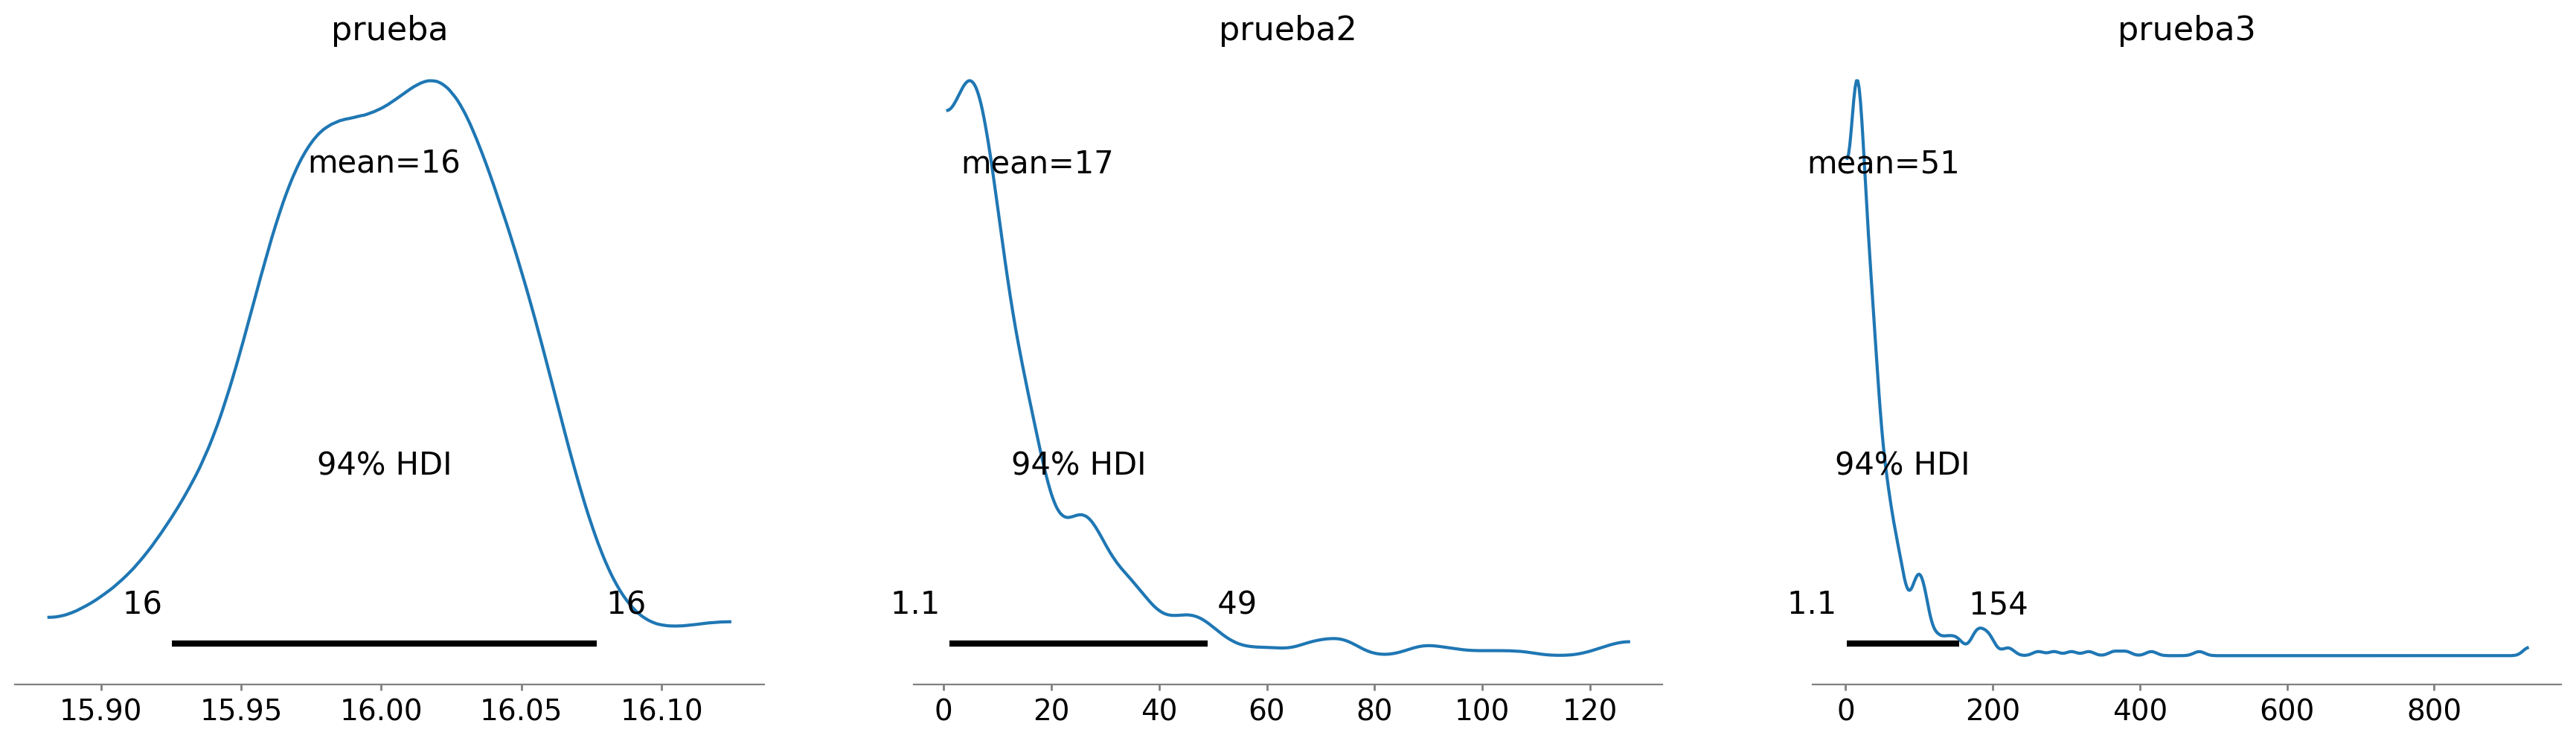

In [10]:
ax = az.plot_posterior(trace)

In [ ]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

(array([0.08348294, 0.07081142, 0.04174147, 0.0223615 , 0.01267152,
        0.0223615 , 0.0089446 , 0.00596307, 0.00670845, 0.00149077,
        0.00223615, 0.00372692, 0.        , 0.00149077, 0.00223615,
        0.        , 0.00149077, 0.00149077, 0.        , 0.00074538,
        0.        , 0.        , 0.00149077, 0.00074538, 0.00074538,
        0.        , 0.00149077, 0.00074538, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00074538, 0.        , 0.        , 0.00074538, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00074538, 0.00074538]),
 array([  0.37487209,   3.72885081,   7.08282953,  10.43680825,
         13.79078697,  17.14476569,  20.49874441,  23.85272313,
         27.20670185,  30.56068057,  33.91465929,  37.26863801,
         40.62261673,  43.97659545,  47.33057417,  50.6845529 ,
         54.03853162,  57.39251034,  60.74648906,  64.10046778

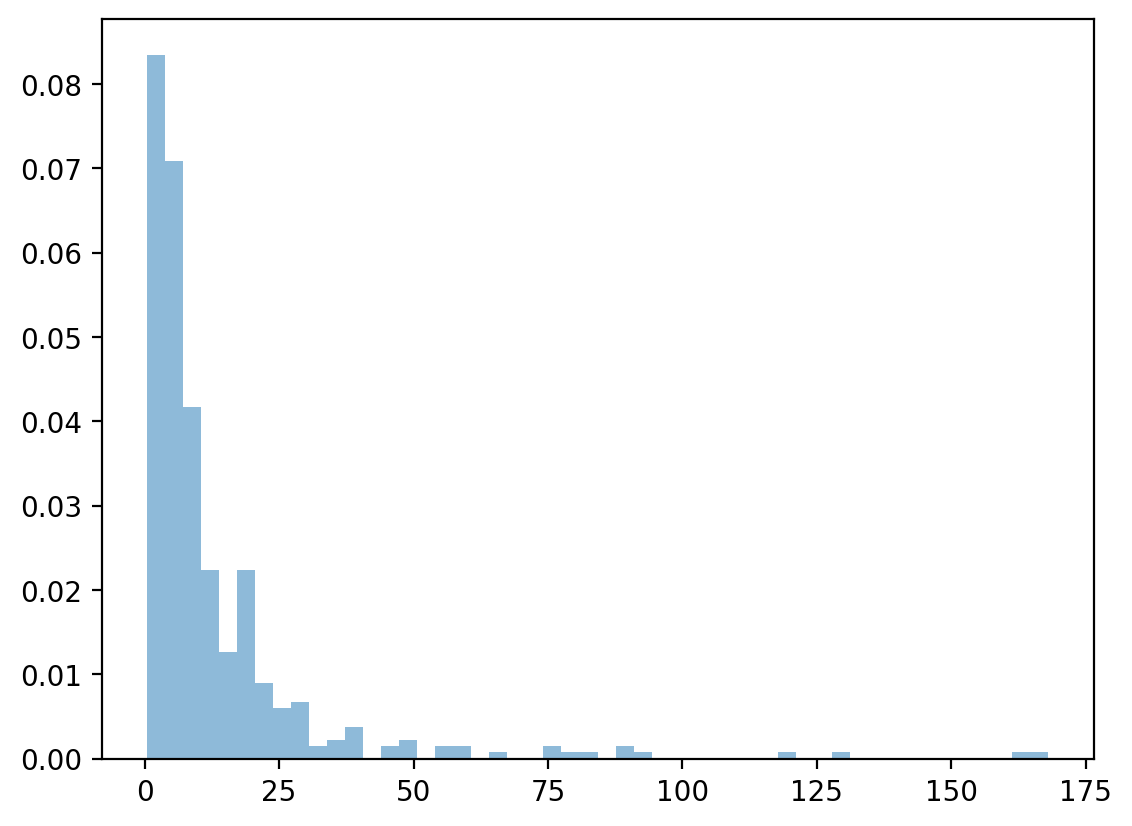

In [ ]:
plt.hist(flat_samps["rho"], bins=50, density=True, alpha=0.5)

(array([[1., 1., 0., ..., 0., 0., 0.],
        [2., 0., 0., ..., 0., 0., 0.],
        [2., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [2., 0., 0., ..., 0., 0., 0.]]),
 array([  0.37487209,  17.14476569,  33.91465929,  50.6845529 ,
         67.4544465 ,  84.2243401 , 100.99423371, 117.76412731,
        134.53402091, 151.30391452, 168.07380812]),
 <a list of 200 BarContainer objects>)

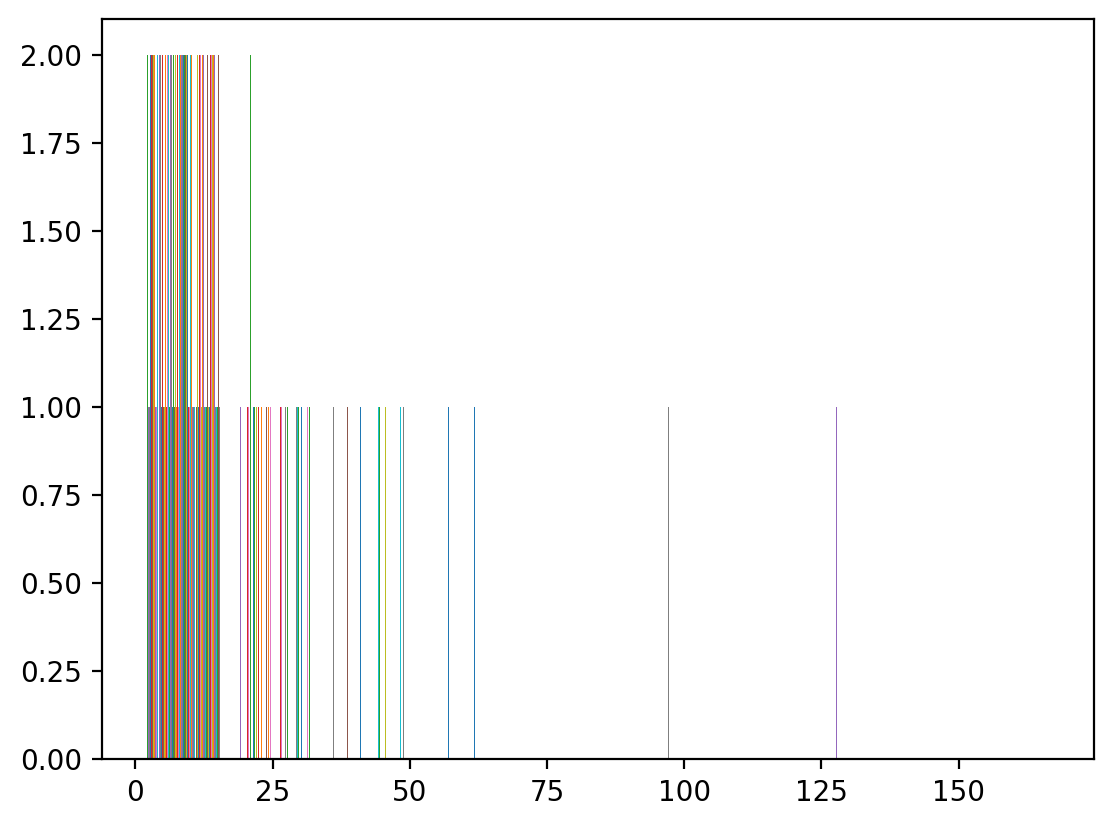

In [ ]:
plt.hist(trace.posterior["rho"].values, bins=10)

# test GP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

t = np.sort(
    np.append(
        np.random.uniform(0, 3.8, 57),
        np.random.uniform(5.5, 10, 68),
    )
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)

true_t = np.linspace(0, 10, 500)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

In [ ]:
import pymc as pm
from celerite2.pymc import GaussianProcess, terms as pm_terms
freq = np.linspace(1.0 / 8, 1.0 / 0.3, 500)
omega = 2 * np.pi * freq
prior_sigma = 2.0

with pm.Model() as model:
    mean = pm.Normal("mean", mu=0.0, sigma=prior_sigma)
    log_jitter = pm.Normal("log_jitter", mu=0.0, sigma=prior_sigma)

    log_sigma1 = pm.Normal("log_sigma1", mu=0.0, sigma=prior_sigma)
    log_rho1 = pm.Normal("log_rho1", mu=0.0, sigma=prior_sigma)
    log_tau = pm.Normal("log_tau", mu=0.0, sigma=prior_sigma)
    term1 = pm_terms.SHOTerm(
        sigma=pm.math.exp(log_sigma1),
        rho=pm.math.exp(log_rho1),
        tau=pm.math.exp(log_tau),
    )

    log_sigma2 = pm.Normal("log_sigma2", mu=0.0, sigma=prior_sigma)
    log_rho2 = pm.Normal("log_rho2", mu=0.0, sigma=prior_sigma)
    term2 = pm_terms.SHOTerm(
        sigma=pm.math.exp(log_sigma2), rho=pm.math.exp(log_rho2), Q=0.25
    )

    kernel = term1 + term2
    gp = GaussianProcess(kernel, mean=mean)
    gp.compute(t, diag=yerr**2 + pm.math.exp(log_jitter), quiet=True)
    gp.marginal("obs", observed=y)

    pm.Deterministic("psd", kernel.get_psd(omega))

    trace = pm.sample(
        tune=100,
        draws=100,
        target_accept=0.9,
        init="adapt_full",
        cores=2,
        chains=1,
        random_seed=34923,
    )